In [3]:
#!pip install pyfftw   # for fast fourier transform

import sys
#import site
import os
import numpy as np

#sys.path.insert(1, site.USER_SITE)
sys.path.insert(1, '/cephyr/users/rixin/Alvis/my_venv_pyfftw/lib/python3.11/site-packages')

import pyfftw # for fast fourier transform
# pyfftw.interfaces.cache.enable()
fftw_num_threads = 6
pyfftw.config.NUM_THREADS    = fftw_num_threads
pyfftw.config.PLANNER_EFFORT = 'FFTW_MEASURE'

import matplotlib.pyplot as plt

from tqdm import tqdm   # to display a loop-progress-bar

import scipy
fftw_num_threads = 6
#from scipy.ndimage.filters import gaussian_filter
from scipy.optimize import fsolve
import h5py

In [4]:
#import pyfftw
#!ls $HOME/my_venv_pyfftw/lib/python3.11/site-packages


In [10]:

class Siv2D():
    def __init__(self,N,Lpi,dRatio,TotalSteps,PartialSteps):
      self.Lpi=Lpi
      self.N=N
      self.dRatio=dRatio
      self.TotalSteps=TotalSteps
      self.PartialSteps=PartialSteps
      self.L_all = 2*np.pi*Lpi
      self.nx    = self.N
      self.ny    = self.N
      self.ny_half=self.ny//2 +1
      kx = np.fft.fftfreq(self.nx, d=1./self.nx)*2*np.pi/self.L_all # this yeilds kx=[0,1,2,...,nx/2-1, -nx/2, -nx/2+1, ...,-2,-1]
      kx = kx.reshape(-1,1)
      ky = np.fft.fftfreq(self.ny, d=1./self.ny)*2*np.pi/self.L_all # first: ky = [0,1,2,...,ny/2-1, -ny/2, -ny/2+1, ...,-2,-1]
      ky = ky[:self.ny_half]
      k2 = ky**2 + kx**2
      k2[0,0] = 1E-15     # to avoid divide-by-zero
      sqk2=np.sqrt(k2)
      sqk2[0,0] = 1E-15
      kx_ = np.copy(kx)  # kx.shape=(nx, 1)
      kx_[0,0]=1E-9
      ky_ = np.copy(ky)  # ky.shape=(   ny)
      ky_[0]=1E-9
      self.kx = kx  # kx.shape=(nx, 1)
      self.ky = ky
      self.k2 = k2  # k2.shape=(nx,ny)
      self.sqk2=sqk2# same shape as k2
      self.kx_=kx_
      self.ky_=ky_
      self.tmp   = pyfftw.empty_aligned( (self.nx,self.ny),          dtype='float64' )
      self.tmpHat= pyfftw.empty_aligned( (self.nx,self.ny_half),     dtype='complex128')
      self.rFFTW      = pyfftw.FFTW( self.tmp,    self.tmpHat,     threads=fftw_num_threads,                             axes=(-2,-1))
      self.irFFTW     = pyfftw.FFTW( self.tmpHat, self.tmp,        threads=fftw_num_threads, direction='FFTW_BACKWARD',  axes=(-2,-1))
      return
    @staticmethod
    def Coeff_Lpi_d_to_mu_nu_tau(Lpi, d_ratio, max_amplitude=0.25):
        #-----------------------------
        def d_to_mu_nu(d_ratio, max_amplitude=0.25):
            #--------------------
            def func_SivaEq_Coeff_Relations(arg, d_ratio, max_amplitude=0.25 ):
                mu, k_star = arg
                nu = mu - d_ratio
                unk = np.zeros(2)
                unk[0]= 4*mu*k_star**3 - 2*nu*k_star - d_ratio
                unk[1]= mu*k_star**4 - nu*k_star**2 - d_ratio * k_star  + max_amplitude
                return unk
            #------------------
            func = lambda arg : func_SivaEq_Coeff_Relations(arg, d_ratio, max_amplitude  )
            root = fsolve(func, [4, 0.6]) # the starting value '4' may affect the result seraching
            mu = root[0]
            nu = mu-d_ratio
            return mu, nu
        #-----------------
        mu,nu = d_to_mu_nu(d_ratio, max_amplitude )
        tau = (Lpi/10*d_ratio) + (1-d_ratio)
        return mu,nu, tau
    def get_Phi_2(self,phixHat, phiyHat):#
      #super().__init__(N, self.Lpi)
      PhiXHat=np.zeros((self.nx,self.ny_half),dtype='complex128')
      PhiYHat=np.zeros((self.nx,self.ny_half),dtype='complex128')

      PhiXHat[:,:] = phixHat #1j*kx *phiHat
      PhiYHat[:,:] = phiyHat #1j*ky *phiHat
      # PhiXHat[:,:] = 1j*kx *phiHat
      # PhiYHat[:,:] = 1j*ky *phiHat

      PhiX = np.zeros( (self.nx, self.ny) , dtype ='float64')
      PhiY = np.zeros( (self.nx, self.ny) , dtype ='float64')
      PhiX[:,:] = self.irFFTW(PhiXHat)
      PhiY[:,:] = self.irFFTW(PhiYHat)

      Phi_2 = np.zeros( (self.nx, self.ny) , dtype ='float64')
      Phi_2[:,:] = PhiX*PhiX+PhiY*PhiY
      Phi2Hat=np.zeros((self.nx,self.ny_half),dtype='complex128')
      Phi2Hat=self.rFFTW(Phi_2)
      return Phi2Hat

    def Solution_Time_Advancement(self, PhiHat0, TotalSteps,mu,nu,tau,dRatio, dStepOutput=1, CFL=1.5):
       dt = CFL* (self.L_all/self.N) / 10
       dt=dt*tau
       phiHat_sols = np.zeros( (TotalSteps, self.nx, self.ny_half), dtype = 'complex128')
       phiHat_sols[0,:,:] = PhiHat0
       phiHat = PhiHat0
       phixHat = np.zeros( (self.nx,self.ny_half), dtype ='complex128' )
       phixHat[:,:] = phiHat*1j*self.kx
       phiyHat = np.zeros( (self.nx, self.ny_half), dtype ='complex128' )
       phiyHat[:,:] = phiHat*1j*self.ky

       Lambda_k = mu*(self.kx**4+2*self.kx**2 *self.ky**2+self.ky**4)-nu*self.k2-dRatio*self.sqk2
       #Lambda_k = -nu*self.k2-dRatio*self.sqk2
       E =  np.exp( -dt/2 * Lambda_k )
       E2 = E**2
       gX=1j*dt*self.kx
       gY=1j*dt*self.ky
       AA=np.zeros( (self.nx, self.ny_half), dtype ='complex128' )
       BB=np.zeros( (self.nx, self.ny_half), dtype ='complex128' )
       CC=np.zeros( (self.nx, self.ny_half), dtype ='complex128' )
       DD=np.zeros( (self.nx, self.ny_half), dtype ='complex128' )
       aX=np.zeros( (self.nx, self.ny_half), dtype ='complex128' )
       bX=np.zeros( (self.nx, self.ny_half), dtype ='complex128' )
       cX=np.zeros( (self.nx, self.ny_half), dtype ='complex128' )
       dX=np.zeros( (self.nx, self.ny_half), dtype ='complex128' )
       aY=np.zeros( (self.nx, self.ny_half), dtype ='complex128' )
       bY=np.zeros( (self.nx, self.ny_half), dtype ='complex128' )
       cY=np.zeros( (self.nx, self.ny_half), dtype ='complex128' )
       dY=np.zeros( (self.nx, self.ny_half), dtype ='complex128' )
       with tqdm( range(1, TotalSteps) ) as pbar:
         for i in pbar:  # tqdm is to display a looping-progress bar
          for j in range(dStepOutput):
            AA=self.get_Phi_2(phixHat,phiyHat)
            aX=gX*AA
            aY=gY*AA
            BB=self.get_Phi_2(E*(phixHat+aX/2),E*(phiyHat+aY/2))
            bX=gX*BB
            bY=gY*BB
            CC=self.get_Phi_2(E*(phixHat+bX/2),E*(phiyHat+bY/2))
            cX=gX*CC
            cY=gY*CC
            DD=self.get_Phi_2(E2*(phixHat)+E*cX,E2*(phiyHat)+E*cY)
            dX=gX*DD
            dY=gY*DD
            phixHat[:,:]=E2*phixHat+(E2*aX+2*E*(bX+cX)+dX)/6
            phiyHat[:,:]=E2*phiyHat+(E2*aY+2*E*(bY+cY)+dY)/6
            phiHat = (phixHat/1j/self.kx_ + phiyHat/1j/self.ky_)/2
            phiHat[0,0]=0
            phixHat = phiHat*1j*self.kx
            phiyHat = phiHat*1j*self.ky
              
          phiHat_sols[i,:,:] = phiHat
       print(' \n\n DNS solution has been advanced for a total of {}*{} time steps with a dt size of {}[s]'.format(TotalSteps, dStepOutput, dt ) )
       return phiHat_sols
#    def InitialCondition(self,level=0.0001,sigmaR=30):
#        '''
#            return a normlized stream-function which gives 'u_rms = 1'
#        '''
#        #self.__init__
#        sigma=self.N/sigmaR
#        RandArray=np.random.random((self.nx,self.ny))
#        RandArray=gaussian_filter(RandArray, sigma=sigma,mode='wrap')
#        RandArrayMaxValue=np.max(np.abs(RandArray))
#        RandArray=RandArray*level/RandArrayMaxValue
#        phi_hat0=self.rFFTW(RandArray)
#        return phi_hat0


    def RandFourier2D(self,k_trun=8,sys_info = None):
      #np.random.seed(42)
      scale=0.2
      k_trun=k_trun/self.Lpi
      theta=np.random.random((self.nx,self.ny_half))*np.pi*2
      d_hat=scale*N/2*np.random.random((self.nx,self.ny_half))* ( np.cos(theta) +  1j *np.sin(theta)  )
      d_hat[self.sqk2>k_trun]=0
      d_hat[0,0]=0
      #d0= scipy.fft.irfft2(d_hat)
      #d0=self.irFFTW(d_hat)
      return d_hat


    def WholeSolver(self,k_trun):
      mu,nu,tau=self.Coeff_Lpi_d_to_mu_nu_tau(self.Lpi,self.dRatio)
      #PhiHat0=self.InitialCondition()
      PhiHat0=self.RandFourier2D(k_trun)
      
      PhiHatSols=self.Solution_Time_Advancement(PhiHat0,self.TotalSteps,mu,nu,tau,self.dRatio,self.PartialSteps )
      return PhiHatSols


In [13]:

#ParentDir='/mimer/NOBACKUP/groups/ml_flame_storage/ml_2dflame/database128'        
ParentDir='/mimer/NOBACKUP/groups/ml_flame_storage/ml_2dflame_extra/database128'        

#for i in range(10,40,5):
for i in range(25,26,5):
#for i in range(20,21,5):
    print(i)
    beta=format(i, '03')
    fullpath=(ParentDir+'/'+'beta'+beta)
    print(fullpath)
    if(not os.path.exists(fullpath)):
        os.mkdir(fullpath)
    
    #for j in range (0,15,5):
    for j in range (10,11,5):
    #for j in range (0,1,5):
        dRat=(format(j/10, '.2f'))
    
        fullpath=(ParentDir+'/'+'beta'+beta+'/'+'dRat'+dRat)
        print(fullpath)
        
        if(not os.path.exists(fullpath)):
            os.mkdir(fullpath)
        
        for k in range(50):
            waveCutOff=8
            
            N=256
            dNSkip=2
            
            Lpi=i #if lpi is too big and the Sim crashes: Increase resolution
            
            TotalSteps=8000  # 8000
            PartialSteps=2
            
            dRatio=j/10
            counter=format(k, '02')
            
            Solver=Siv2D(N,Lpi,dRatio,TotalSteps,PartialSteps)
            
            PhiHatSols=Solver.WholeSolver(waveCutOff)
            
            phihat_aaa =np.zeros(( Solver.nx,Solver.ny_half),dtype='complex128')
            phiSols=np.zeros((TotalSteps,Solver.N//dNSkip,Solver.N//dNSkip),dtype=np.float32)
            
            for idx,  psiHat in tqdm(  enumerate(  PhiHatSols ) ):
                phihat_aaa =np.zeros((Solver.nx,Solver.ny_half),dtype='complex128')
                phihat_aaa[:,:] = psiHat
                phiSols[idx,:,:]= Solver.irFFTW( phihat_aaa )[::2,::2].astype(np.float32)
                
            #filename = 'Run' + counter + '.h5'
            filename='Run'+counter+'.npy'
            np.save(os.path.join(fullpath, filename), phiSols)

            print('created Data for beta= ', beta, 'dRatio=', dRat, 'WaveCutOff= ', waveCutOff, filename )
            
                    

25
/mimer/NOBACKUP/groups/ml_flame_storage/ml_2dflame_extra/database128/beta025
/mimer/NOBACKUP/groups/ml_flame_storage/ml_2dflame_extra/database128/beta025/dRat1.00


100%|██████████| 7999/7999 [02:01<00:00, 65.62it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4123.54it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run00.npy


100%|██████████| 7999/7999 [02:01<00:00, 65.82it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4556.19it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run01.npy


100%|██████████| 7999/7999 [02:01<00:00, 65.60it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4304.91it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run02.npy


100%|██████████| 7999/7999 [02:02<00:00, 65.42it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4373.52it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run03.npy


100%|██████████| 7999/7999 [02:00<00:00, 66.21it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4408.66it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run04.npy


100%|██████████| 7999/7999 [02:02<00:00, 65.32it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4122.18it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run05.npy


100%|██████████| 7999/7999 [02:03<00:00, 64.69it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4490.90it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run06.npy


100%|██████████| 7999/7999 [02:00<00:00, 66.46it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4587.73it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run07.npy


100%|██████████| 7999/7999 [02:00<00:00, 66.35it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4156.25it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run08.npy


100%|██████████| 7999/7999 [02:03<00:00, 64.67it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4565.28it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run09.npy


100%|██████████| 7999/7999 [02:02<00:00, 65.52it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4151.70it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run10.npy


100%|██████████| 7999/7999 [01:59<00:00, 66.89it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4605.03it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run11.npy


100%|██████████| 7999/7999 [02:09<00:00, 61.93it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:02, 3980.93it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run12.npy


100%|██████████| 7999/7999 [02:08<00:00, 62.40it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:02, 3891.16it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run13.npy


100%|██████████| 7999/7999 [02:05<00:00, 63.95it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:02, 3943.10it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run14.npy


100%|██████████| 7999/7999 [02:01<00:00, 65.77it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4309.59it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run15.npy


100%|██████████| 7999/7999 [02:04<00:00, 64.10it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4227.16it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run16.npy


100%|██████████| 7999/7999 [02:04<00:00, 64.29it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4068.59it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run17.npy


100%|██████████| 7999/7999 [02:02<00:00, 65.27it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4297.43it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run18.npy


100%|██████████| 7999/7999 [02:02<00:00, 65.55it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4207.47it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run19.npy


100%|██████████| 7999/7999 [02:02<00:00, 65.46it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4105.34it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run20.npy


100%|██████████| 7999/7999 [02:01<00:00, 65.60it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4397.47it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run21.npy


100%|██████████| 7999/7999 [02:01<00:00, 65.77it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4356.25it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run22.npy


100%|██████████| 7999/7999 [01:59<00:00, 66.87it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4420.91it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run23.npy


100%|██████████| 7999/7999 [01:59<00:00, 67.06it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4111.90it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run24.npy


100%|██████████| 7999/7999 [02:00<00:00, 66.53it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4418.20it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run25.npy


100%|██████████| 7999/7999 [01:57<00:00, 68.22it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4155.94it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run26.npy


100%|██████████| 7999/7999 [02:04<00:00, 64.22it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4216.78it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run27.npy


100%|██████████| 7999/7999 [02:00<00:00, 66.16it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4477.78it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run28.npy


100%|██████████| 7999/7999 [01:59<00:00, 66.81it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4472.16it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run29.npy


100%|██████████| 7999/7999 [01:59<00:00, 66.98it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4511.50it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run30.npy


100%|██████████| 7999/7999 [02:00<00:00, 66.50it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4433.79it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run31.npy


100%|██████████| 7999/7999 [01:59<00:00, 67.13it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4445.66it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run32.npy


100%|██████████| 7999/7999 [02:03<00:00, 64.74it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4076.07it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run33.npy


100%|██████████| 7999/7999 [01:59<00:00, 66.82it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4493.29it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run34.npy


100%|██████████| 7999/7999 [02:00<00:00, 66.55it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4301.06it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run35.npy


100%|██████████| 7999/7999 [02:00<00:00, 66.20it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4316.92it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run36.npy


100%|██████████| 7999/7999 [02:03<00:00, 64.98it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4377.53it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run37.npy


100%|██████████| 7999/7999 [02:02<00:00, 65.45it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4362.25it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run38.npy


100%|██████████| 7999/7999 [02:03<00:00, 64.92it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4520.22it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run39.npy


100%|██████████| 7999/7999 [02:01<00:00, 66.00it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4490.60it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run40.npy


100%|██████████| 7999/7999 [02:00<00:00, 66.17it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4418.61it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run41.npy


100%|██████████| 7999/7999 [02:00<00:00, 66.20it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4302.72it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run42.npy


100%|██████████| 7999/7999 [02:00<00:00, 66.27it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4199.54it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run43.npy


100%|██████████| 7999/7999 [02:02<00:00, 65.43it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4063.06it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run44.npy


100%|██████████| 7999/7999 [02:00<00:00, 66.48it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4165.57it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run45.npy


100%|██████████| 7999/7999 [02:00<00:00, 66.65it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4470.23it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run46.npy


100%|██████████| 7999/7999 [02:03<00:00, 65.01it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:02, 3940.26it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run47.npy


100%|██████████| 7999/7999 [02:02<00:00, 65.52it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4218.27it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run48.npy


100%|██████████| 7999/7999 [02:00<00:00, 66.52it/s]


 

 DNS solution has been advanced for a total of 8000*2 time steps with a dt size of 0.23009711818284617[s]


8000it [00:01, 4099.49it/s]


created Data for beta=  025 dRatio= 1.00 WaveCutOff=  8 Run49.npy


In [ ]:
#np.any( np.isnan( phiSols) )


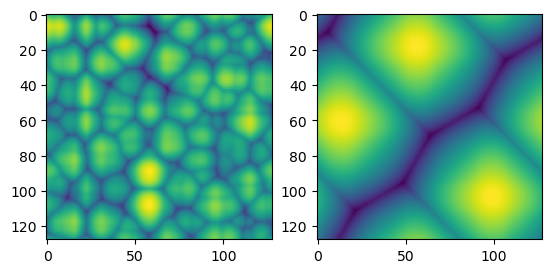

In [23]:
%matplotlib inline
fig,axs=plt.subplots(1,2,)
axs[0].imshow( phiSols[100,:,:] )
axs[1].imshow( phiSols[5800,:,:] ) #-1
plt.show()

In [ ]:
#N=256
#Lpi=10 #if lpi is too big and the Sim crashes: Increase resolution
#TotalSteps=100
#PartialSteps=4
#dRatio=0.2
#Solver=Siv2D(N,Lpi,dRatio,TotalSteps,PartialSteps)
#PhiHatSols=Solver.WholeSolver(8)
#phiSols=np.zeros((TotalSteps,Solver.N,Solver.N),dtype=np.float32)
#for idx,  psiHat in tqdm(  enumerate(  PhiHatSols ) ):
#    phihat_aaa[:,:] = psiHat
#    phiSols[idx,:,:]=Solver.irFFTW( phihat_aaa ).astype(np.float32)

In [ ]:
fig = plt.figure(figsize = (4,4))
ax = fig.add_subplot()
plt.close()
#-----

def update_plt(i):

    ax.clear()
    # Reduce the animation size by showing a small portion of pixels (Colab will complain)
    ax.imshow( phiSols[ i, :,:] , cmap = 'jet')

    ax.set_title( ' t_step ={}'.format(i)   )
    return ax
#----------------
import matplotlib
from matplotlib import rc
matplotlib.rcParams['animation.embed_limit'] = 2**128
import matplotlib.animation as animation
rc('animation', html='jshtml')
#print(TotalSteps)
ani = animation.FuncAnimation(fig=fig, func=update_plt, frames=TotalSteps, interval=150)
ani

In [ ]:
phiSols.dtype